In [1]:
print('Continue?(1=YES/0=NO)')
continue_training=bool(int(input()))

Continue?(1=YES/0=NO)
0


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-beta1
# import logging
# logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2
import random
import time
import shutil, os
from collections import deque
from tensorflow.keras import layers

from IPython import display
from tqdm import tqdm

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/GAN/"
folder = "PGGAN/PGGAN"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
imgs = []
files = os.listdir(path+"pokemon/")
random.shuffle(files)
file_range = 10 if len(files)-1 > 4000 else len(files)-1
for i in tqdm(range(0, file_range)):
    img = mpimg.imread(path+"pokemon/"+str(files[i]))
    imgs.append(img)

def resize(images, size, BATCH_SIZE):
    i_list = []
#     for i in tqdm(images):
    for i in images:
        i = cv2.resize(i, (size, size), interpolation = cv2.INTER_AREA)
        i_list.append(i)


    train_images = np.array(i_list).astype('float32')
    train_images = train_images / 255
    BUFFER_SIZE = 60000
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_dataset

100%|██████████| 868/868 [00:20<00:00, 46.96it/s]


In [4]:
class VAE_model(tf.keras.Model):
    @tf.function
    def __init__(self):
        super(VAE_model, self).__init__()
        
        
        self.relu = layers.LeakyReLU()
        self.avg_pool = layers.AveragePooling2D(strides=2, padding='same')
        
        
        self.layer_input_512x512 = layers.Conv2D(16, (1, 1), strides=1, padding='same')
        self.layer_512x512 = layers.Conv2D(16, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_256x256 = layers.Conv2D(16, (1, 1), strides=1, padding='same')
        self.layer_256x256 = layers.Conv2D(32, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_128x128 = layers.Conv2D(32, (1, 1), strides=1, padding='same')
        self.layer_128x128 = layers.Conv2D(32, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_64x64 = layers.Conv2D(32, (1, 1), strides=1, padding='same')
        self.layer_64x64 = layers.Conv2D(64, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_32x32 = layers.Conv2D(64, (1, 1), strides=1, padding='same')
        self.layer_32x32 = layers.Conv2D(64, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_16x16 = layers.Conv2D(64, (1, 1), strides=1, padding='same')
        self.layer_16x16 = layers.Conv2D(128, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_8x8 = layers.Conv2D(128, (1, 1), strides=1, padding='same')
        self.layer_8x8 = layers.Conv2D(128, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_4x4 = layers.Conv2D(128, (1, 1), strides=1, padding='same', name='layer_input_4x4')
        self.layer_4x4 = layers.Conv2D(256, (3, 3), strides=1, padding='same', name='layer_4x4')
        
        
        self.flatten = layers.Flatten()
        self.layer_out = layers.Dense(200)
        
        
        self.fader_total = 500
        self.fader = self.fader_total - 1
        
        
        

        noise = tf.random.normal([1, 4, 4, 3])
        output = self.model_4x4(noise)
        print(4, output[0].shape)

        noise = tf.random.normal([1, 8, 8, 3])
        output = self.model_8x8(noise)
        print(8, output[0].shape)

        noise = tf.random.normal([1, 16, 16, 3])
        output = self.model_16x16(noise)
        print(16, output[0].shape)

        noise = tf.random.normal([1, 32, 32, 3])
        output = self.model_32x32(noise)
        print(32, output[0].shape)

        noise = tf.random.normal([1, 64, 64, 3])
        output = self.model_64x64(noise)
        print(64, output[0].shape)

        noise = tf.random.normal([1, 128, 128, 3])
        output = self.model_128x128(noise)
        print(128, output[0].shape)

        noise = tf.random.normal([1, 256, 256, 3])
        output = self.model_256x256(noise)
        print(256, output[0].shape)

        noise = tf.random.normal([1, 512, 512, 3])
        output = self.model_512x512(noise)
        print(512, output[0].shape)
        
        
        self.layer_4x4_vars_main = self.layer_out.trainable_weights + self.layer_4x4.trainable_weights
        self.layer_4x4_vars = self.layer_4x4_vars_main + self.layer_input_4x4.trainable_weights
        
        self.layer_8x8_vars_main = self.layer_4x4_vars_main + self.layer_8x8.trainable_weights
        self.layer_8x8_vars = self.layer_8x8_vars_main + self.layer_input_8x8.trainable_weights + self.layer_input_4x4.trainable_weights
        
        self.layer_16x16_vars_main = self.layer_8x8_vars_main + self.layer_16x16.trainable_weights
        self.layer_16x16_vars = self.layer_16x16_vars_main + self.layer_input_16x16.trainable_weights + self.layer_input_8x8.trainable_weights
        
        self.layer_32x32_vars_main = self.layer_16x16_vars_main + self.layer_32x32.trainable_weights
        self.layer_32x32_vars = self.layer_32x32_vars_main + self.layer_input_32x32.trainable_weights + self.layer_input_16x16.trainable_weights
        
        self.layer_64x64_vars_main = self.layer_32x32_vars_main + self.layer_64x64.trainable_weights
        self.layer_64x64_vars = self.layer_64x64_vars_main + self.layer_input_64x64.trainable_weights + self.layer_input_32x32.trainable_weights
        
        self.layer_128x128_vars_main = self.layer_64x64_vars_main + self.layer_128x128.trainable_weights
        self.layer_128x128_vars = self.layer_128x128_vars_main + self.layer_input_128x128.trainable_weights + self.layer_input_64x64.trainable_weights
        
        self.layer_256x256_vars_main = self.layer_128x128_vars_main + self.layer_256x256.trainable_weights
        self.layer_256x256_vars = self.layer_256x256_vars_main + self.layer_input_256x256.trainable_weights + self.layer_input_128x128.trainable_weights
        
        self.layer_512x512_vars_main = self.layer_256x256_vars_main + self.layer_512x512.trainable_weights
        self.layer_512x512_vars = self.layer_512x512_vars_main + self.layer_input_512x512.trainable_weights + self.layer_input_256x256.trainable_weights
        
        
        
        
    @tf.function
    def model_4x4(self, inputs, training=False):
        x = self.layer_input_4x4(inputs)
        x = self.relu(x)
        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
     
    @tf.function   
    def model_8x8(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_4x4(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_8x8(inputs)
        x = self.relu(x)
        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
       
    @tf.function 
    def model_16x16(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_8x8(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_16x16(inputs)
        x = self.relu(x)
        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
     
    @tf.function   
    def model_32x32(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_16x16(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_32x32(inputs)
        x = self.relu(x)
        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
        
    @tf.function
    def model_64x64(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_32x32(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_64x64(inputs)
        x = self.relu(x)
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
        
    @tf.function
    def model_128x128(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_64x64(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_128x128(inputs)        
        x = self.relu(x)
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
        
    @tf.function
    def model_256x256(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_128x128(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_256x256(inputs)        
        x = self.relu(x)
        x = self.layer_256x256(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
        
    @tf.function
    def model_512x512(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_256x256(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_512x512(inputs)
        x = self.relu(x)
        x = self.layer_512x512(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        
        x = self.layer_256x256(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        mean, logvar = tf.split(x, num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        x = eps * tf.exp(logvar * .5) + mean
        
        return x, mean, logvar
        
    
    
    

VAE = VAE_model()

4 (1, 100)
8 (1, 100)
16 (1, 100)
32 (1, 100)
64 (1, 100)
128 (1, 100)
256 (1, 100)
512 (1, 100)


In [5]:
class generator_model(tf.keras.Model):
    @tf.function
    def __init__(self):
        super(generator_model, self).__init__()
        
        self.relu = layers.LeakyReLU()
        self.sigmoid = layers.Activation('sigmoid')
        self.layer_upsample = layers.UpSampling2D()
        
        self.layer_dense = layers.Dense(4*4*256, use_bias=False, input_shape=(100,))
        self.layer_dense_norm = layers.BatchNormalization()
        self.reshape_4x4 = layers.Reshape((4, 4, 256))
        self.layer_out_4x4 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        
        
        self.layer_8x8 = layers.Conv2D(128, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_8x8 = layers.BatchNormalization()
        self.layer_out_8x8 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        

        self.layer_16x16 = layers.Conv2D(128, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_16x16 = layers.BatchNormalization()
        self.layer_out_16x16 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        

        self.layer_32x32 = layers.Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_32x32 = layers.BatchNormalization()
        self.layer_out_32x32 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)


        self.layer_64x64 = layers.Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_64x64 = layers.BatchNormalization()
        self.layer_out_64x64 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)


        self.layer_128x128 = layers.Conv2D(32, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_128x128 = layers.BatchNormalization()
        self.layer_out_128x128 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        

        self.layer_256x256 = layers.Conv2D(32, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_256x256 = layers.BatchNormalization()
        self.layer_out_256x256 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        

        self.layer_512x512 = layers.Conv2D(16, (3, 3), strides=1, padding='same', use_bias=False)
        self.layer_norm_512x512 = layers.BatchNormalization()
        self.layer_out_512x512 = layers.Conv2D(3, (1, 1), strides=1, padding='same', use_bias=False)
        
        
        self.op = tf.keras.optimizers.Adam(1e-4)
        self.fader_total = 500
        self.fader = self.fader_total - 1
        
        
        noise = tf.random.normal([1, 100])

        output = self.model_4x4(noise)
        print(output.shape)

        output = self.model_8x8(noise)
        print(output.shape)

        output = self.model_16x16(noise)
        print(output.shape)

        output = self.model_32x32(noise)
        print(output.shape)

        output = self.model_64x64(noise)
        print(output.shape)

        output = self.model_128x128(noise)
        print(output.shape)

        output = self.model_256x256(noise)
        print(output.shape)

        output = self.model_512x512(noise)
        print(output.shape)
        
        
        self.layer_4x4_vars_main = self.layer_dense.trainable_weights + self.layer_dense_norm.trainable_weights
        self.layer_4x4_vars = self.layer_4x4_vars_main + self.layer_out_4x4.trainable_weights
        
        self.layer_8x8_vars_main = self.layer_4x4_vars_main + self.layer_8x8.trainable_weights + self.layer_norm_8x8.trainable_weights
        self.layer_8x8_vars = self.layer_8x8_vars_main + self.layer_out_8x8.trainable_weights + self.layer_out_4x4.trainable_weights
        
        self.layer_16x16_vars_main = self.layer_8x8_vars_main + self.layer_16x16.trainable_weights + self.layer_norm_16x16.trainable_weights
        self.layer_16x16_vars = self.layer_16x16_vars_main + self.layer_out_16x16.trainable_weights + self.layer_out_8x8.trainable_weights
        
        self.layer_32x32_vars_main = self.layer_16x16_vars_main + self.layer_32x32.trainable_weights + self.layer_norm_32x32.trainable_weights
        self.layer_32x32_vars = self.layer_32x32_vars_main + self.layer_out_32x32.trainable_weights + self.layer_out_16x16.trainable_weights
        
        self.layer_64x64_vars_main = self.layer_32x32_vars_main + self.layer_64x64.trainable_weights + self.layer_norm_64x64.trainable_weights
        self.layer_64x64_vars = self.layer_64x64_vars_main + self.layer_out_64x64.trainable_weights + self.layer_out_32x32.trainable_weights
        
        self.layer_128x128_vars_main = self.layer_64x64_vars_main + self.layer_128x128.trainable_weights + self.layer_norm_128x128.trainable_weights
        self.layer_128x128_vars = self.layer_128x128_vars_main + self.layer_out_128x128.trainable_weights + self.layer_out_64x64.trainable_weights
        
        self.layer_256x256_vars_main = self.layer_128x128_vars_main + self.layer_256x256.trainable_weights + self.layer_norm_256x256.trainable_weights
        self.layer_256x256_vars = self.layer_256x256_vars_main + self.layer_out_256x256.trainable_weights + self.layer_out_128x128.trainable_weights
        
        self.layer_512x512_vars_main = self.layer_256x256_vars_main + self.layer_512x512.trainable_weights + self.layer_norm_512x512.trainable_weights
        self.layer_512x512_vars = self.layer_512x512_vars_main + self.layer_out_512x512.trainable_weights + self.layer_out_256x256.trainable_weights
        
        
    @tf.function
    def model_4x4(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        x = self.layer_out_4x4(x)
        x = self.sigmoid(x)
        return x

    @tf.function
    def model_8x8(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)

        old = self.layer_out_4x4(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_8x8(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
        
    @tf.function
    def model_16x16(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)

        old = self.layer_out_8x8(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_16x16(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
        
    @tf.function
    def model_32x32(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)

        old = self.layer_out_16x16(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_32x32(x)
        x = self.layer_norm_32x32(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_32x32(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
        
    @tf.function
    def model_64x64(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_32x32(x)
        x = self.layer_norm_32x32(x, training=training)
        x = self.relu(x)

        old = self.layer_out_32x32(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_64x64(x)
        x = self.layer_norm_64x64(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_64x64(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
        
    @tf.function
    def model_128x128(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_32x32(x)
        x = self.layer_norm_32x32(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_64x64(x)
        x = self.layer_norm_64x64(x, training=training)
        x = self.relu(x)

        old = self.layer_out_64x64(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_128x128(x)
        x = self.layer_norm_128x128(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_128x128(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
       
    @tf.function 
    def model_256x256(self, inputs, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_32x32(x)
        x = self.layer_norm_32x32(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_64x64(x)
        x = self.layer_norm_64x64(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_128x128(x)
        x = self.layer_norm_128x128(x, training=training)
        x = self.relu(x)

        old = self.layer_out_128x128(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_256x256(x)
        x = self.layer_norm_256x256(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_256x256(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
       
    @tf.function 
    def model_512x512(self, inputs, fader=1, training=False):
        x = self.layer_dense(inputs)
        x = self.layer_dense_norm(x, training=training)
        x = self.relu(x)
        x = self.reshape_4x4(x)
        
        x = self.layer_upsample(x)
        x = self.layer_8x8(x)
        x = self.layer_norm_8x8(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_16x16(x)
        x = self.layer_norm_16x16(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_32x32(x)
        x = self.layer_norm_32x32(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_64x64(x)
        x = self.layer_norm_64x64(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_128x128(x)
        x = self.layer_norm_128x128(x, training=training)
        x = self.relu(x)
        
        x = self.layer_upsample(x)
        x = self.layer_256x256(x)
        x = self.layer_norm_256x256(x, training=training)
        x = self.relu(x)

        old = self.layer_out_256x256(x)
        old = self.layer_upsample(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_upsample(x)
        x = self.layer_512x512(x)
        x = self.layer_norm_512x512(x, training=training)
        x = self.relu(x)
        
        x = self.layer_out_512x512(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.sigmoid(x)
        
        return x
    
    

generator = generator_model()

(1, 4, 4, 3)
(1, 8, 8, 3)
(1, 16, 16, 3)
(1, 32, 32, 3)
(1, 64, 64, 3)
(1, 128, 128, 3)
(1, 256, 256, 3)
(1, 512, 512, 3)


In [6]:
class discriminator_model(tf.keras.Model):
    @tf.function
    def __init__(self):
        super(discriminator_model, self).__init__()
        
        self.relu = layers.LeakyReLU()
        self.dropout = layers.Dropout(0.3)
        self.avg_pool = layers.AveragePooling2D(strides=2, padding='same')
        self.gaus_noise = layers.GaussianNoise(.5)
        
        
        self.layer_input_512x512 = layers.Conv2D(16, (1, 1), strides=1, padding='same')
        self.layer_512x512 = layers.Conv2D(16, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_256x256 = layers.Conv2D(16, (1, 1), strides=1, padding='same')
        self.layer_256x256 = layers.Conv2D(32, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_128x128 = layers.Conv2D(32, (1, 1), strides=1, padding='same')
        self.layer_128x128 = layers.Conv2D(32, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_64x64 = layers.Conv2D(32, (1, 1), strides=1, padding='same')
        self.layer_64x64 = layers.Conv2D(64, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_32x32 = layers.Conv2D(64, (1, 1), strides=1, padding='same')
        self.layer_32x32 = layers.Conv2D(64, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_16x16 = layers.Conv2D(64, (1, 1), strides=1, padding='same')
        self.layer_16x16 = layers.Conv2D(128, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_8x8 = layers.Conv2D(128, (1, 1), strides=1, padding='same')
        self.layer_8x8 = layers.Conv2D(128, (3, 3), strides=1, padding='same')
        
        
        self.layer_input_4x4 = layers.Conv2D(128, (1, 1), strides=1, padding='same', name='layer_input_4x4')
        self.layer_4x4 = layers.Conv2D(256, (3, 3), strides=1, padding='same', name='layer_4x4')
        
        
        self.flatten = layers.Flatten()
        self.layer_out = layers.Dense(1, name='layer_out')
        
        
        self.op = tf.keras.optimizers.Adam(1e-4)
        self.fader_total = 500
        self.fader = self.fader_total - 1
        

        noise = self.gaus_noise(tf.random.normal([1, 4, 4, 3]))
        output = self.model_4x4(noise)
        print(4, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 8, 8, 3]))
        output = self.model_8x8(noise)
        print(8, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 16, 16, 3]))
        output = self.model_16x16(noise)
        print(16, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 32, 32, 3]))
        output = self.model_32x32(noise)
        print(32, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 64, 64, 3]))
        output = self.model_64x64(noise)
        print(64, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 128, 128, 3]))
        output = self.model_128x128(noise)
        print(128, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 256, 256, 3]))
        output = self.model_256x256(noise)
        print(256, output.shape)

        noise = self.gaus_noise(tf.random.normal([1, 512, 512, 3]))
        output = self.model_512x512(noise)
        print(512, output.shape)
        
        
        self.layer_4x4_vars_main = self.layer_out.trainable_weights + self.layer_4x4.trainable_weights
        self.layer_4x4_vars = self.layer_4x4_vars_main + self.layer_input_4x4.trainable_weights
        
        self.layer_8x8_vars_main = self.layer_4x4_vars_main + self.layer_8x8.trainable_weights
        self.layer_8x8_vars = self.layer_8x8_vars_main + self.layer_input_8x8.trainable_weights + self.layer_input_4x4.trainable_weights
        
        self.layer_16x16_vars_main = self.layer_8x8_vars_main + self.layer_16x16.trainable_weights
        self.layer_16x16_vars = self.layer_16x16_vars_main + self.layer_input_16x16.trainable_weights + self.layer_input_8x8.trainable_weights
        
        self.layer_32x32_vars_main = self.layer_16x16_vars_main + self.layer_32x32.trainable_weights
        self.layer_32x32_vars = self.layer_32x32_vars_main + self.layer_input_32x32.trainable_weights + self.layer_input_16x16.trainable_weights
        
        self.layer_64x64_vars_main = self.layer_32x32_vars_main + self.layer_64x64.trainable_weights
        self.layer_64x64_vars = self.layer_64x64_vars_main + self.layer_input_64x64.trainable_weights + self.layer_input_32x32.trainable_weights
        
        self.layer_128x128_vars_main = self.layer_64x64_vars_main + self.layer_128x128.trainable_weights
        self.layer_128x128_vars = self.layer_128x128_vars_main + self.layer_input_128x128.trainable_weights + self.layer_input_64x64.trainable_weights
        
        self.layer_256x256_vars_main = self.layer_128x128_vars_main + self.layer_256x256.trainable_weights
        self.layer_256x256_vars = self.layer_256x256_vars_main + self.layer_input_256x256.trainable_weights + self.layer_input_128x128.trainable_weights
        
        self.layer_512x512_vars_main = self.layer_256x256_vars_main + self.layer_512x512.trainable_weights
        self.layer_512x512_vars = self.layer_512x512_vars_main + self.layer_input_512x512.trainable_weights + self.layer_input_256x256.trainable_weights
        
        
    @tf.function
    def model_4x4(self, inputs, training=False):
        x = self.layer_input_4x4(inputs)
        x = self.relu(x)
        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
     
    @tf.function   
    def model_8x8(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_4x4(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_8x8(inputs)
        x = self.relu(x)
        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
       
    @tf.function 
    def model_16x16(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_8x8(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_16x16(inputs)
        x = self.relu(x)
        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
     
    @tf.function   
    def model_32x32(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_16x16(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_32x32(inputs)
        x = self.relu(x)
        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
        
    @tf.function
    def model_64x64(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_32x32(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_64x64(inputs)
        x = self.relu(x)
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
        
    @tf.function
    def model_128x128(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_64x64(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_128x128(inputs)        
        x = self.relu(x)
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
        
    @tf.function
    def model_256x256(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_128x128(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_256x256(inputs)        
        x = self.relu(x)
        x = self.layer_256x256(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
        
    @tf.function
    def model_512x512(self, inputs, training=False):
        old = self.avg_pool(inputs)
        old = self.layer_input_256x256(old)
        old = self.relu(old)
        old = old * 1-(self.fader/self.fader_total)
        
        x = self.layer_input_512x512(inputs)
        x = self.relu(x)
        x = self.layer_512x512(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = x * (self.fader/self.fader_total)
        
        x = x + old
        x = self.dropout(x)
        
        x = self.layer_256x256(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_128x128(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_64x64(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_32x32(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_16x16(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_8x8(x)
        x = self.avg_pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_4x4(x)
        x = self.relu(x)
        x = self.dropout(x)

        
        x = self.flatten(x)
        x = self.layer_out(x)
        
        return x
        
    
    
    

discriminator = discriminator_model()

4 (1, 1)
8 (1, 1)
16 (1, 1)
32 (1, 1)
64 (1, 1)
128 (1, 1)
256 (1, 1)
512 (1, 1)


In [0]:
cross_entropy_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy_regulerizer = tf.keras.losses.CategoricalCrossentropy()

@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def regulerizer_loss(z, mean, logvar, generated_images, images):
    logpx_z = cross_entropy_regulerizer(generated_images, images)
    logpz = tf.math.reduce_mean(log_normal_pdf(z, 0., 0.))
    logqz_x = tf.math.reduce_mean(log_normal_pdf(z, mean, logvar))
    return (logpx_z + logpz - logqz_x)

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_logits(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def generator_loss(fake_output):
    total_loss = cross_entropy_logits(tf.ones_like(fake_output), fake_output)
    return total_loss


In [8]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 49


    
seed = tf.Variable(tf.random.normal([num_examples_to_generate, noise_dim]))

checkpoint_dir = path + folder +'_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(seed=seed,
                                 step=tf.Variable(0),
                                 level=tf.Variable(0),
                                 VAE=VAE,
                                 generator=generator,
                                 discriminator=discriminator)



if continue_training:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(checkpoint.step)
    print('Loaded!')
else:
    try:
        os.mkdir(path+folder+'_imgs')
    except: pass
    try:
        os.mkdir(path+folder+'_checkpoints')
    except: pass
    try:
        os.mkdir(path+folder+'_graphs')
    except: pass
    print(checkpoint.step)
    print('New!')

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
New!


In [0]:
@tf.function
def train_step_4x4(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_4x4(images, training=True)
        
        generated_images = generator.model_4x4(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_4x4(images_with_gaus, training=True)
        fake_output = discriminator.model_4x4(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_4x4_vars+VAE.layer_4x4_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_4x4_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_4x4_vars+VAE.layer_4x4_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_4x4_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_8x8(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_8x8(images, training=True)
        
        generated_images = generator.model_8x8(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_8x8(images_with_gaus, training=True)
        fake_output = discriminator.model_8x8(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_8x8_vars+VAE.layer_8x8_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_8x8_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_8x8_vars+VAE.layer_8x8_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_8x8_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_16x16(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_16x16(images, training=True)
        
        generated_images = generator.model_16x16(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_16x16(images_with_gaus, training=True)
        fake_output = discriminator.model_16x16(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_16x16_vars+VAE.layer_16x16_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_16x16_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_16x16_vars+VAE.layer_16x16_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_16x16_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_32x32(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_32x32(images, training=True)
        
        generated_images = generator.model_32x32(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_32x32(images_with_gaus, training=True)
        fake_output = discriminator.model_32x32(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_32x32_vars+VAE.layer_32x32_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_32x32_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_32x32_vars+VAE.layer_32x32_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_32x32_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_64x64(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_64x64(images, training=True)
        
        generated_images = generator.model_64x64(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_64x64(images_with_gaus, training=True)
        fake_output = discriminator.model_64x64(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_64x64_vars+VAE.layer_64x64_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_64x64_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_64x64_vars+VAE.layer_64x64_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_64x64_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_128x128(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_128x128(images, training=True)
        
        generated_images = generator.model_128x128(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_128x128(images_with_gaus, training=True)
        fake_output = discriminator.model_128x128(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_128x128_vars+VAE.layer_128x128_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_128x128_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_128x128_vars+VAE.layer_128x128_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_128x128_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_256x256(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_256x256(images, training=True)
        
        generated_images = generator.model_256x256(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_256x256(images_with_gaus, training=True)
        fake_output = discriminator.model_256x256(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_256x256_vars+VAE.layer_256x256_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_256x256_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_256x256_vars+VAE.layer_256x256_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_256x256_vars))
    
    return gen_loss, disc_loss
    
    
@tf.function
def train_step_512x512(images):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        images_with_gaus = discriminator.gaus_noise(images)
        
        z, mean, logvar = VAE.model_512x512(images, training=True)
        
        generated_images = generator.model_512x512(z, training=True)
        generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
        real_output = discriminator.model_512x512(images_with_gaus, training=True)
        fake_output = discriminator.model_512x512(generated_images_with_gaus, training=True)
        
        
        reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
        gen_loss = generator_loss(fake_output)
        total_gen_loss = gen_loss - (0.1*reg_loss)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.layer_512x512_vars+VAE.layer_512x512_vars)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.layer_512x512_vars)

    generator.op.apply_gradients(zip(gradients_of_generator, generator.layer_512x512_vars+VAE.layer_512x512_vars))
    discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.layer_512x512_vars))
    
    return gen_loss, disc_loss
    
    
# @tf.function
# def train_step(images, VAE_model, Gen_model, Dis_model):
#     noise = tf.random.normal([images.shape[0], noise_dim])

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
#         images_with_gaus = discriminator.gaus_noise(images)
        
#         z, mean, logvar = VAE_model(images, training=True)
        
#         generated_images = Gen_model(z, training=True)
#         generated_images_with_gaus = discriminator.gaus_noise(generated_images)

        
#         real_output = Dis_model(images_with_gaus, training=True)
#         fake_output = Dis_model(generated_images_with_gaus, training=True)
        
        
#         reg_loss = regulerizer_loss(z, mean, logvar, generated_images_with_gaus, images)
#         gen_loss = generator_loss(fake_output)
#         disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables+VAE.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#     generator.op.apply_gradients(zip(gradients_of_generator, generator.trainable_variables+VAE.trainable_variables))
#     discriminator.op.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [0]:
def train(base_epochs=3000, base_batchs=128):
    growing_model = [   (train_step_4x4, generator.model_4x4, 4, int(base_batchs/(2**0)), base_epochs),
                            (train_step_8x8, generator.model_8x8, 8, int(base_batchs/(2**0)), base_epochs),
                            (train_step_16x16, generator.model_16x16, 16, int(base_batchs/(2**0)), base_epochs),
                            (train_step_32x32, generator.model_32x32, 32, int(base_batchs/(2**0)), base_epochs),
                            (train_step_64x64, generator.model_64x64, 64, int(base_batchs/(2**0)), base_epochs),
                            (train_step_128x128, generator.model_128x128, 128, int(base_batchs/(2**1)), base_epochs),
                            (train_step_256x256, generator.model_256x256, 256, int(base_batchs/(2**2)), base_epochs)]#,
    #                         (train_step_512x512, generator.model_512x512, 512, int(base_batchs/(2**5)), base_epochs)   ]

    for i in range(checkpoint.level.numpy(), len(growing_model)):
        (train_step, Gen_model, size, batch_size, epochs) = growing_model[i]
        
        train_dataset = resize(imgs, size, batch_size)
        discriminate_loss_list = deque(maxlen=500)
        generate_loss_list = deque(maxlen=500)
        
        for epoch in range(checkpoint.step.numpy(), epochs+1):
            start = time.time()
            gen_epoch_loss = []
            disc_epoch_loss = []
            
            if generator.fader < generator.fader_total:
                VAE.fader = epoch
                generator.fader = epoch
                discriminator.fader = epoch

            for image_batch in train_dataset:
                gen_loss, disc_loss = train_step(image_batch)
                gen_epoch_loss.append(tf.keras.activations.tanh(gen_loss))
                disc_epoch_loss.append(tf.keras.activations.tanh(disc_loss))
                
            discriminate_loss_list.append(tf.reduce_mean(disc_epoch_loss))
            generate_loss_list.append(tf.reduce_mean(gen_epoch_loss))
            
            if (epoch) % 15 == 0:
                checkpoint.step.assign(epoch)
                checkpoint.level.assign(i)
                checkpoint.save(file_prefix = checkpoint_prefix)
                generate_and_save_images(Gen_model, size, epoch, seed)
                plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list, size)
                gen_std = tf.math.reduce_std(list(generate_loss_list)[-200:]).numpy()
                disc_std = tf.math.reduce_std(list(discriminate_loss_list)[-200:]).numpy()
                gen_dif = tf.math.reduce_std(list(generate_loss_list)[-150:]).numpy()/gen_std
                dis_dif = tf.math.reduce_std(list(discriminate_loss_list)[-150:]).numpy()/disc_std
                print('Generator', gen_std, gen_dif)
                print('Discriminator', disc_std, dis_dif)
                if epoch > 1000 and gen_dif < .9 and dis_dif < .9:
                    break
                
                
            print ('Time for layer {}, epoch {} is {} sec'.format(size, epoch, time.time()-start))
        del train_dataset
        
        checkpoint.step.assign(0)
        checkpoint.level.assign(i+1)
        checkpoint.save(file_prefix = checkpoint_prefix)
        
#         generate_and_save_images(Gen_model, size, epochs, seed)

In [0]:
def generate_and_save_images(model, layer, epoch, test_input, show=True):
    
    display.clear_output(wait=True)
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow(predictions[i, :, :, :].numpy())
        plt.axis('off')

    plt.savefig(path+folder+'_imgs/image_{:01d}x{:01d}_{:04d}.png'.format(layer, layer, epoch))
    
    if show:
        plt.show()

In [0]:
def plot_graph_disc_and_gan(discriminate_loss_list, generate_loss_list, layer):
    plt.figure(2)
    plt.clf()
    plt.ylim(top=1, bottom=0)
    plt.plot(generate_loss_list, c='g')
    plt.plot(discriminate_loss_list, c='r')
    plt.savefig(path+folder+'_graphs/image_{:01d}x{:01d}.png'.format(layer, layer))
    plt.show()

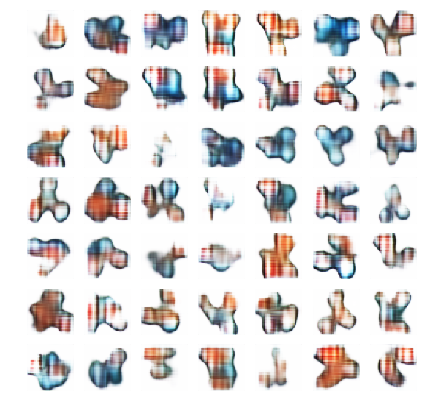

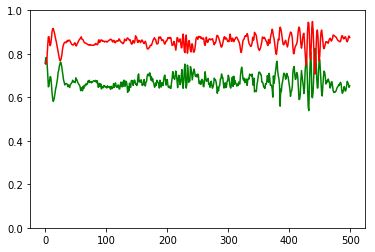

Generator 0.044249292 1.1074393
Discriminator 0.035235837 1.1033773
Time for layer 64, epoch 690 is 7.567643165588379 sec
Time for layer 64, epoch 691 is 2.9908745288848877 sec
Time for layer 64, epoch 692 is 3.1583023071289062 sec
Time for layer 64, epoch 693 is 3.1701693534851074 sec
Time for layer 64, epoch 694 is 3.169173002243042 sec
Time for layer 64, epoch 695 is 3.1766746044158936 sec
Time for layer 64, epoch 696 is 3.1733176708221436 sec


KeyboardInterrupt: ignored

In [17]:
# train(base_epochs=5)
train()